In [1]:
import sys
import numpy as np

class Node:
    def __init__(self, val, next_node=None):
        self.val = val
        self.next_node = next_node
        
class LinkedList:
    def __init__(self, head):
        self.head = head
        
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm

In [31]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 
from IPython.display import HTML, display

sys.path.insert(0, '../')
from flightgoggles.env import *

# -- CONSTANT VARS ---
num_waypoints = 20
radius = 10
circle_center = [0, -10., -30.]

EPSILON = 1.
#2 * np.pi  * radius * 0.2
#2 * np.pi * radius / num_waypoints * 6 # how decide this??
LOOPS = 1


AMBITION = 5.2


# -- END CONSTANT VARS -- 
string = "with rad {}, center at {}, num_waypoints {}, epsilon {:.2}, & AMBITION {:.2}...".format(
    radius, circle_center, num_waypoints, EPSILON, AMBITION)

theta = np.linspace(0, 2*np.pi * LOOPS, num_waypoints)

theta_perpen = theta + np.pi / 2
waypoint_coords = np.vstack((circle_center[0] + radius*np.cos(theta), #x
                             circle_center[1] + radius*np.sin(theta), #y
                             circle_center[2] * np.ones(num_waypoints), #z
                             theta_perpen))                             # attitude

head = Node(waypoint_coords.T[0])
waypoint_ll = LinkedList(head)
p = head
for n in waypoint_coords.T:
    curr = Node(n)
    p.next_node = curr
    p = curr

if __name__ == "__main__":
    
    # drone flips over when going too fast ? ? ? SimSpeed adjustment needed??
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSimSpeed.yaml") # 30 max_speed/accel multicopterDynamicsSimSpeed
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = waypoint_ll.head.val[:3],
                          attitude_euler_angle=np.array([0., 0., theta_perpen[0]]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
    curr_vel = env.get_state("uav1")["velocity"]

    fol_accumulator = None
    pos_accumulator = np.array([curr_pos])
    per_accumulator = None
    
    rand_accumulator = None
    
    curr_waypoint = waypoint_ll.head
    
    time_counter = 0
    crash = False
    while curr_waypoint:
        if (not curr_waypoint.next_node):
            EPSILON = 0.01
        
        while np.linalg.norm(curr_pos - curr_waypoint.val[:3]) >= EPSILON:
            time_counter += 0.01
            curr_pos = env.get_state("uav1")["position"]
            curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
            curr_vel = env.get_state("uav1")["velocity"]
            
            curr_pos_perpend_on_circle = circle_center + np.append(radius * normalize(curr_pos[:2] - circle_center[:2]), 0)
    
            if (not curr_waypoint.next_node):
                target_pose = curr_waypoint.val
            else:
                target_pose = (curr_pos_perpend_on_circle + 
                               normalize(curr_waypoint.val[:3] - curr_pos_perpend_on_circle) * AMBITION)
                
                # curr_att considers x=0 as pi/2
                att_to_target = np.arctan2(target_pose[1] - curr_pos[1],
                                           target_pose[0] - curr_pos[0])

                target_pose = np.append(target_pose, att_to_target) # attitude

#                 print("TARGET ATT", target_pose[3])
#                 print("CURR ATT", curr_att)
                
#                 print("SUPPOSED CIRCLE ANGLE, ", np.arctan2(target_pose[1], target_pose[0]))
            # alternate next waypoint criteria, to avoid having to tune EPSILON overmuch
#             if np.linalg.norm(curr_pos - curr_waypoint.val[:3]) < np.linalg.norm(curr_pos - follow_point):
#                 break

            collided = env.proceed_waypoint(vehicle_id="uav1",
                                            waypoint_command=target_pose,
                                            duration=0.01)
    
            rand_accumulator = np.append(rand_accumulator, target_pose[3])
    
            if per_accumulator is None:
                per_accumulator = np.array([curr_pos_perpend_on_circle])
            else:
                per_accumulator = np.vstack((per_accumulator, curr_pos_perpend_on_circle))

            if fol_accumulator is None:
                fol_accumulator = np.array([target_pose])
            else:
                fol_accumulator = np.vstack((fol_accumulator, target_pose))
    
            pos_accumulator = np.vstack((pos_accumulator, curr_pos))
            if collided:
                crash = True
                break
        if crash:
            print("CRASHED! :(")
            break
        
        curr_waypoint = curr_waypoint.next_node
    
    f = open("observation notes target circular.txt", "a")
    if not crash:
        f.write(string + " it took {:.2f} sec\n".format(time_counter))
    else:
        f.write(string + " it crashed :(\n")
    f.close()
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))
        
    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=300)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()











CRASHED! :(
Final pose [ -7.01 -26.09 -19.53   2.5 ]


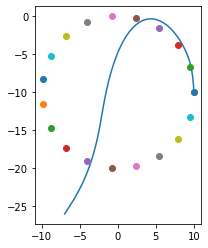

In [32]:
# Orange dots are the waypoints, dotted are waypoints
# coloration suggests the order
import itertools
import matplotlib.pyplot as plt

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

plt.gca().set_aspect('equal', adjustable='box')
plt.plot(pos_accumulator.T[0], pos_accumulator.T[1])
for column in waypoint_coords.T:
    plt.plot(column[0], column[1], 'o')

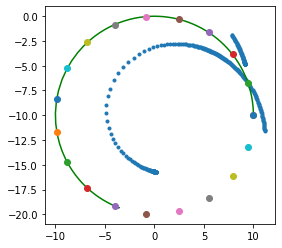

In [33]:
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(fol_accumulator.T[0], fol_accumulator.T[1], '.')
# plt.plot(pos_accumulator.T[0], pos_accumulator.T[1], 'r')
plt.plot(per_accumulator.T[0], per_accumulator.T[1], 'g')
for column in waypoint_coords.T:
    plt.plot(column[0], column[1], 'o')

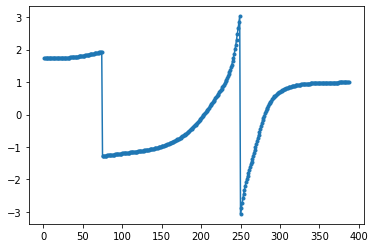

In [34]:
import matplotlib.pyplot as plt
x = np.arange(rand_accumulator.size)
y = rand_accumulator
#linear with a gap b/c pi to -pi
plt.plot(x, y, marker='.')